# COVID-19 Impact on Digital Learning

The covid-19 pandemic has affected education systems around the world, leading to the near total closure of schools, early childhood education and care services, universities and colleges. Most governments decided to temporarily shut down an educational institution in an attempt to reduce the spread of covid-19. As of January 2021, around 825 million learners are affected due to school closures in response to the pandemic.

Therefore, UNESCO has recommended the use of distance learning programs and open educational apps and platforms that schools and teachers can use to reach distance learners and limit disruption to education.

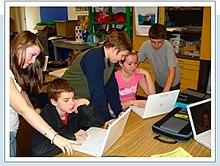

### The consequences of covid-19 on education in the United States

1. In March 2020, schools in the United States began to close.
2. 55.1 million students in 124,000 US public and private schools are affected by school closures.
3. The effect of the generalized closure of schools has been felt nationwide and has worsened several social inequalities, gender, technology, academic success, etc ...
4. Most schools shifted to online learning that lead an  another problem like unequal access to technology, unequal access to educational resource, absenteeism of students and accomodation for special needs student, etc ...

The objective of this notebook is to better understand and measure the scope and impact of the pandemic on digital learning of students based on the two challenges below.

- **state of digital learning 2020**
- **the link between engagement in digital learning and factors such as district demographics, broadband access, and state / national policies and events.**

In this notebook, we are talking about:

- **[School closures in the worldwide](#closures)**: 
    - **[USA vs ROW](#usr)**
    - **[USA school closure](#usc)**
- **[Challenge of the digital learning in USA](#challenge)**

**Source**: 
- [Impact of COVID-19 on education in the United States](https://en.wikipedia.org/wiki/Impact_of_COVID-19_on_education_in_the_United_States)
-[UNESCO School Closures](https://data.humdata.org/showcase/unesco-school-closures)
-[Global School Closures COVID-19](https://data.humdata.org/m/dataset/global-school-closures-covid19)
-[US school closure & distance learning database](https://osf.io/tpwqf/files/)


In [ ]:
import matplotlib 
import seaborn as sns
import statsmodels as sm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopy as gpy
import geopandas as gpd
from warnings import filterwarnings
import os

In [ ]:
sns.set()
%matplotlib inline
filterwarnings('ignore')

In [ ]:
for root, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(root, filename))

In [ ]:
!pip install xlrd
!pip install openpyxl

<a id="closures"></a>

# School closures in the worldwide

In [ ]:
file1 = '/kaggle/input/school-closures/covid_impact_education.csv'
file2 = '/kaggle/input/school-closures/COVID_19_Education data on school closures - Schools data.csv'
file3 = '/kaggle/input/school-closures/COVID-19 US state policy database 8_3_2021.xlsx'
file4 = '/kaggle/input/school-closures/duration_school_closures.csv'
file5 = '/kaggle/input/school-closures/school-closure-evolution.xlsx'

In [ ]:
covidImpEduc = pd.read_csv(file1)# covid-19 impact education data
educSchClos = pd.read_csv(file2)# COVID_19_Education data on school closures - Schools data 
usPolicy = pd.read_excel(file3) # COVID-19 US state policy database 8_3_2021
durationSchcl = pd.read_csv(file4) # duration_school_closures
schCloEvo = pd.read_excel(file5) # school-closure-evolution

### Exploration data and information attribute.
In this part, we explore different school closures dataset. I give some information attributes

In [ ]:
covidImpEduc.head()

In [ ]:
educSchClos.head()

In [ ]:
usPolicy.head()

In [ ]:
durationSchcl.head()

In [ ]:
schCloEvo.head()

In [ ]:
covidImpEduc.info()

In [ ]:
educSchClos.info()

In [ ]:
usPolicy.info()

In [ ]:
durationSchcl.info()

**Definitions attributes**

- **Full school closures** refer to situations where all schools were closed at the nation-wide level due to COVID-19.
- **Partial school closures** refer to school closures in some regions or for some grades, or with reduced in-person instruction. 

In [ ]:
schCloEvo.info()

#### Checking missing value.

In [ ]:
educSchClos.isnull().sum()[educSchClos.isnull().sum()>0]

**ISO3 country** have missing value, we can remove it. And also remove column Date from source and also Date update done. 

In [ ]:
educSchClos.dropna(inplace=True)

In [ ]:
educSchClos.drop([educSchClos.columns[5], educSchClos.columns[6]], axis=1, inplace=True)

In [ ]:
#educSchClos#.drop(index=0, inplace=True)

<a id="usr"></a>

## EDA and Visualization: USA and ROW

###  Covid-19 impact on education.

In [ ]:
covidImpEduc.columns

In [ ]:
print(f"The number of country in this data are: {covidImpEduc['Country'].nunique()}.")

In [ ]:
print(f"Number of status is: {covidImpEduc['Status'].nunique()} which are: {covidImpEduc['Status'].unique()}")

**Definition**
- **Closed due to COVID-19**: Government-mandated closures of educational institutions affecting most or all of the student population enrolled from pre-primary through to upper secondary levels [ISCED levels 0 to 3]. In most cases, various distance learning strategies are deployed to ensure educational continuity.
- **Academic break**: Most schools across the country are on scheduled academic breaks. All study during this period is suspended.
- **Fully open**: For the majority of schools, classes are being held exclusively in person, noting that measures to ensure safety and hygiene in schools vary considerably from context to context and/or by level of education.
- **Partially open**: Schools are : (a) open/closed in certain regions only; and/or (b) open/closed for some grade levels/age groups only; and/or (c) open but with reduced in-person class time, combined with distance learning (hybrid approach).

**Source**: [UNESCO School Closures](https://data.humdata.org/showcase/unesco-school-closures)

In [ ]:
plt.figure(figsize=(15,5))
gc = sns.countplot(x='Status', data=covidImpEduc)
plt.title(f"Covid-19 impact on education from 2020-02-17 to 2021-07-31.", fontsize=18)
plt.show()

<div class= "alert alert-info">
    <p><b>Fully open</b> and <b>Academic break</b> are majorities in this data. Between 2020-02-17 to 2021-07-31, we are going to see how different countries, Covid-19 impact education.</p>
</div>     

In [ ]:
#initialize
country_status = {}
name_ctry = covidImpEduc.ISO.unique()# name of the countries

In [ ]:
for u in covidImpEduc.Status.unique().tolist():# for each status
    row = covidImpEduc[covidImpEduc.Status == u]# we select data.
    #we want to get table such that columns is status and index is the country 
    country_status[u] = {c:row[row.ISO == c].ISO.value_counts().values[0] if c in row.ISO.unique()
                        else 0 for c in name_ctry}

In [ ]:
#Dataframe our data
country_status = pd.DataFrame(country_status)

In [ ]:
#This table shows how many each status appear in each country between 2020-02-17 to 2021-07-31.
#For example, YEMEN have fully open school 29 times, partially open school 6 times, close school due to
#Covid-19 14 times and Academic break 54 times with permutation.
country_status.tail()

#### Status map

We create new data to map the different status.

In [ ]:
#load world earth data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [ ]:
#merge it with country_status
statusMap = world.merge(country_status, right_on=country_status.index, left_on='iso_a3', suffixes=('', ''))

In [ ]:
colors = ['Greens', 'Blues', 'OrRd', 'cividis_r']
fig = plt.figure(figsize=(20,20))
for i, u in enumerate(covidImpEduc.Status.unique().tolist()):
    ax = fig.add_subplot(4, 1, i+1)
    plt.suptitle("Global school status between 2020-02-17 to 2021-07-31.", fontsize=20)
    statusMap.plot(cmap=colors[i], column=u, legend=True, scheme='quantiles', k=5, ax=ax)
    ax.set_title(f'School status: {u}', fontsize=15)
plt.show()

<div class= "alert alert-info">
     
<p> According to the evolution of the pandemic between the two dates given on the graph, we see that the countries tends to adopt the four situations and others not. </p>

   <p> For example, the majorities of African countries have fully opened their schools over a very long period.
Others have completely closed schools because of Covid-19 to continue digital learning, for example Mexico, Brazil and India.</p>

 <p> For USA, we see that the four situations are present despite the partial opening of schools and the end of academic teaching are majorities. You should know that in USA, it is the states that defines their type of strategy on the issue of the impact of covid-19 on education.</p>
 </div>

### COVID-19 Education data on school closures

In [ ]:
educSchClos.replace(['Partially Open', 'fully open'], ['Fully open', 'Partially open'], inplace=True)

In [ ]:
#some data are recorded in this format 16,500,100 but pandas does not recognize it.
#we create function convertString2Int to fix it.
def convertString2Int(row):
    if row == '--' or row == '..':
        return 0
    else:
        return int("".join(u for u in str(row).split(',')))

In [ ]:
cols = educSchClos.columns# columns
#apply function 
educSchClos[cols[2]] = educSchClos[cols[2]].apply(convertString2Int)
educSchClos[cols[3]] = educSchClos[cols[3]].apply(convertString2Int)

In [ ]:
#define 
fully_open = educSchClos[educSchClos['Status of school closures']=='Fully open']
closed = educSchClos[educSchClos['Status of school closures']=='Closed due to COVID-19']
partial_open = educSchClos[educSchClos['Status of school closures']=='Partially open']
aca_break = educSchClos[educSchClos['Status of school closures'] =='Academic break']

In [ ]:
#remove duplicated
fully_open.drop_duplicates(inplace=True,subset=educSchClos.columns)
closed.drop_duplicates(inplace=True,subset=educSchClos.columns)
partial_open.drop_duplicates(inplace=True,subset=educSchClos.columns)
aca_break.drop_duplicates(inplace=True,subset=educSchClos.columns)

#### Fully Open school

Majorities of the countries have chosen social distancing and hygiene in the schools. we prefer to see it in the map.   

In [ ]:
map_fullOpen = world.merge(fully_open, right_on='ISO3 country',  left_on='iso_a3', suffixes=('', ''))

In [ ]:
fig1 = plt.figure(figsize=(15,20), dpi=200)
for i, u in enumerate([cols[2], cols[3]]):
    ax = fig1.add_subplot(2, 1, i+1)
    plt.suptitle("Fully open school.", fontsize=20)
    map_fullOpen.plot(cmap='Greens', column=u, legend=True, scheme='quantiles', k=3, ax=ax)
    ax.set_title(f'{u}', fontsize=15)
plt.show()

<div class="alert alert-info">
     
<p>You should know that the countries that have fully opened their schools are those who have succeeded in controlling the level of spread of Covid-19 i.e. the recovery rate is higher than the transmission rate with a very low case fatality rate for example Cameroon, China, Japan, etc ...</p>
</div>

**Source**

- [Sars-Cov II](https://www.kaggle.com/lumierebatalong/neural-network-versus-sars-cov-ii)
- [sars-cov2-africa-and-the-row](https://www.kaggle.com/lumierebatalong/sars-cov2-africa-and-the-row)

In [ ]:
print(f'Total {cols[2]} for Fully open school in the world are: {fully_open[cols[2]].sum()}.')

In [ ]:
print(f'Total {cols[3]} for Fully open school in the world are: {fully_open[cols[3]].sum()}.')

#### Partially open school

Here, many countries have partially open school in some region and opt digital learning.

In [ ]:
map_par = world.merge(partial_open, right_on='ISO3 country',  left_on='iso_a3', suffixes=('', ''))

In [ ]:
fig1 = plt.figure(figsize=(15,20))
for i, u in enumerate([cols[2], cols[3]]):
    ax = fig1.add_subplot(2, 1, i+1)
    plt.suptitle("Partially open school.", fontsize=20)
    map_par.plot(cmap='OrRd', column=u, legend=True, scheme='quantiles', k=3, ax=ax)
    ax.set_title(f'{u}', fontsize=15)
plt.show()

In [ ]:
print(f'Total {cols[2]} for Partially open school in the world are: {partial_open[cols[2]].sum()}.')

In [ ]:
print(f'Total {cols[3]} for Partially open school in the world are: {partial_open[cols[3]].sum()}.')

#### Closed due to Covid-19

Countries without control over the evolution of the pandemic find themselves constrained to close their schools and then use digital learning as recommended by UNESCO. This situation can be changed.

In [ ]:
closed.plot(x=cols[1], y=[cols[2], cols[3]], kind='barh', subplots=True, figsize=(10, 20),
            sharex=True, sharey=True, logx=True)
plt.show()

#### Academic break

In [ ]:
print(f'Total {cols[2]} for Close school in the world are: {closed[cols[2]].sum()}.')

In [ ]:
print(f'''Total {cols[3]} for Close school in the world are: {closed[cols[3]].sum()}.''')

In [ ]:
aca_break

### Duration school closures

We present the duration school closures of each country in the map. 

In [ ]:
durationSchcl.describe()

In [ ]:
plt.figure(figsize=(10,5))
sns.heatmap(durationSchcl.corr(), center=0, annot=True)
plt.show()

<div class="alert alert-info">
<p>We choose a four last columns. Because it is period of school and strong correlate with others features.</p>
</div>

In [ ]:
school = durationSchcl[['ISO', 'Country']+list(durationSchcl.columns[5:])]

In [ ]:
#merge it with country_status
geoSchool = world.merge(school, right_on='ISO', left_on='iso_a3', suffixes=('', ''))

<a id="school"></a>

In [ ]:
colors = ['Reds', 'Blues', 'OrRd', 'cividis_r']
figx = plt.figure(figsize=(20,20))
for i, u in enumerate(school.columns[2:]):
    ax = figx.add_subplot(4, 1, i+1)
    plt.suptitle("Duration school closures.", fontsize=20)
    geoSchool.plot(cmap=colors[i], column=u, legend=True, scheme='quantiles', k=3, ax=ax)
    ax.set_title(f'School period: {u}', fontsize=15)
plt.show()

<div class ="alert alert-info">
<p> During the school period (Mar-Aug 2020) on time of the peak of pandemic (in March, Europe was the main focus with Italy), USA had not completely closed its schools as well as this school year Sep 2020-Jun 2021. USA have opted for the partial closure of schools between March-August 2020 with a duration of 19 weeks. Unfortunately, this partial closure increases by 20 more weeks (see table below) i.e. a total of 39 weeks. This is the cause of the 3rd or 4th waves and the delta variant also that the inefficient of vaccine against disease.</p>

<p>Between the Sep 2020-Jun 2021 school year, many countries are using digital learning recommended by UNESCO. Therefore, many countries have undergone third or fourth wave and variant Covid-19 for example, <b>USA(Cal.C20), Brazil(P.4), India (hybrid variant), England(Delta) etc</b> ... </p>

<p><b>N.B:</b> The duration of school closure depends on the pandemic control of the country.</p>
</div>

#### Duration school closures ranking.

In [ ]:
school.set_index('Country', inplace=True)

In [ ]:
plt.suptitle(f'10 most commons {school.columns[1]}')
school[school.columns[1]].sort_values(ascending=False)[:10].plot(kind='bar', legend=True, figsize=(15,5))
plt.ylabel('weeks')
plt.show()

<div class="alert alert-info">
    <p>Some countries are chosen to full close school due to Covid-19.</p>
</div>

In [ ]:
plt.suptitle(f'10 most commons {school.columns[2]}')
school[school.columns[2]].sort_values(ascending=False)[:10].plot(kind='bar', legend=True, figsize=(15,5))
plt.ylabel('weeks')
plt.show()

In [ ]:
plt.suptitle(f'10 most commons {school.columns[3]}')
school[school.columns[3]].sort_values(ascending=False)[:10].plot(kind='bar', legend=True, figsize=(15,5))
plt.ylabel('weeks')
plt.show()

In [ ]:
plt.suptitle(f'10 most commons {school.columns[4]}')
school[school.columns[4]].sort_values(ascending=False)[:10].plot(kind='bar', legend=True, figsize=(15,5))
plt.ylabel('weeks')
plt.show()

<div class="alert alert-info">
    <p>USA and others countries are prefered to close partially their school due to Covid-19.</p>
</div>

<a id="usc"></a>

## USA school closure

In this section, we are studying the school closure evolution and see school closure in each state.

In [ ]:
us = usPolicy[['STATE','POSTCODE', 'CLSCHOOL']]

#### The date a state closed K-12 public schools statewide

In [ ]:
us.drop(index=[0,1,2,3], inplace=True)

In [ ]:
str(us['CLSCHOOL'].unique().tolist()[0])

In [ ]:
state = {}
for u in us.CLSCHOOL.unique().tolist():# for each date
    row = us[us.CLSCHOOL == u]# we select data.
    #we want to get table such that columns is date
    state[str(u)] = len(row['STATE'].tolist())

In [ ]:
#sorted 
temp = {}
for u in sorted(state.keys()):
    temp[u] = state[u]
state = temp

<a id=k12></a>

In [ ]:
plt.figure(figsize=(9,8))
plt.pie(list(state.values()), labels=list(state.keys()), shadow=True, startangle=180, autopct='%1.1f%%',
       explode=(0,0.1,0,0,0,0,0,0,0,0,0))
plt.suptitle('The date a state closed K-12 public schools statewide.', fontsize=18)
plt.axis('equal')
plt.show()

<div class = "alert alert-info">
<p> Only 41.2% of the states had chosen to close school on 2020-03-16 00:00:00. And the next day, 17.6% of the states had also chosen to close school.</p>
</div>

#### School closure evolution

In [ ]:
usa = schCloEvo[schCloEvo.Country == 'United States of America'][['Date', 'Status']]

We consider
- 1 = Full open
- 0.5 = Partially open
- 0 = Academic break

In [ ]:
#Labelize 
def labelizer(row):
    if row == 'Fully open':
        return 1
    elif row == 'Partially open':
        return 0.5
    else:
        return 0

In [ ]:
usa['Label_status'] = usa['Status'].apply(labelizer)

In [ ]:
usa.plot(x='Date', y='Label_status', figsize=(15,5), title='School closure evolution in USA..')
plt.show()

<div class="alert alert-info">
    <p> This graph gives us a square signal with a period to be determined. The periodic form of the signal may be due to the partial opening of schools and academic shutdown of each state and each day.</p>
</div>

In [ ]:
from statsmodels.tsa import seasonal  

In [ ]:
label_status = usa.set_index('Date')['Label_status']

In [ ]:
season = seasonal.seasonal_decompose(label_status, period=90)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(15,15))
season.trend.plot(ax=ax1)
season.seasonal.plot(ax=ax2)
season.resid.plot(ax=ax3)
plt.show()

<div class ="alert alert-info">
<p> By seeing this graph, we can tell that the school closure status changes after 3 months according to the pandemic situation. </p>
</div>

### Short conclusion

<div class="alert alert-success">
    <p> Despite the spread of Covid-19 in the world and the impact on education, each country try to control the learning crisis; by trying partially open school. UNESCO recommend each country to use online learning or distance learning but this solution have huge challenge that we discover below.</p>    
</div>

<a id="challenge"></a>

# Part I:  The challenges of the digital learning in USA

We are going to study
1. district_info
2. product_info

## District study

In [ ]:
file6='/kaggle/input/learnplatform-covid19-impact-on-digital-learning/districts_info.csv'

In [ ]:
district = pd.read_csv(file6)

In [ ]:
district.head()

In [ ]:
district.tail()

In [ ]:
district.info()

In [ ]:
district.isnull().sum()[district.isnull().sum()>0]

In [ ]:
#We remove NAN from state column because we have not information. 
district.dropna(subset=['state'], inplace=True)

In [ ]:
district.info()

In [ ]:
from sklearn.impute import SimpleImputer

In [ ]:
imputer = SimpleImputer(strategy = "most_frequent")

In [ ]:
cols_with_missing = [col for col in district.columns if district[col].isnull().any()]

In [ ]:
imputed_data = imputer.fit_transform(district[cols_with_missing])

In [ ]:
district[cols_with_missing] = imputed_data

In [ ]:
district.info()

### Visualization

In [ ]:
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15,15))
sns.countplot(y='state',  data=district, ax=axis1)
sns.countplot(y='state', hue='locale', data=district, ax=axis2)
plt.suptitle('State distribution.', fontsize=18)
plt.show()

In [ ]:
district['state'].mode()

In [ ]:
#We create function for plotting
def categoricalPlot(y1=None, y2=None, hue=None, data=None, title=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
    plt.suptitle(title, fontsize=18)
    sns.countplot(y=y1, hue=hue, data=data, ax=ax1)
    ax1.set_title('States', fontsize=12)
    sns.countplot(x=y2, hue=hue, data=data, ax=ax2)
    ax2.set_title('Locale', fontsize=12)
    plt.show()

In [ ]:
categoricalPlot(y1='state', y2='pct_black/hispanic', hue='locale', data=district,
                title='Percentage of students identified as black/hispanic.')

In [ ]:
categoricalPlot(y1='state', y2='pct_free/reduced', hue='locale', data=district,
                title='Percentage of students eligible for free or reduced-price lunch.')

In [ ]:
categoricalPlot(y1='state', y2='county_connections_ratio', hue='locale', data=district,
                title='Residential fixed high-speed connections over 200 kbps.')

<div class="alert alert-info">
    <p> 22 states give connection ratio to resident between 0.18 and 1. Only North Dakota state give connection ratio between 1 and 2.</p>
</div>

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
sns.countplot(y='pp_total_raw', hue='locale', data=district, ax=ax1[0])
sns.countplot(y='pp_total_raw', hue='pct_free/reduced', data=district, ax=ax1[1])
sns.countplot(y='pp_total_raw', hue='pct_black/hispanic', data=district, ax=ax2[0])
sns.countplot(y='pp_total_raw', hue='county_connections_ratio', data=district, ax=ax2[1])
plt.suptitle('Per-pupil total expenditure by each category. ', fontsize=20)
plt.show()

<div class="alert alert-info">
    <p>Majorities of student expends betwween 8000 and 10000 dollars.</p>
</div>

<a id="black"></a>

In [ ]:
sns.countplot(hue='pct_black/hispanic', x='county_connections_ratio', data=district)
plt.title('Connectivity of the black/hispanic students.')
plt.show()

<div class="alert alert-info">
<p>This graph shows that many black or hispanic student have connection ratio in their resident between 0.18 and 1. And only 20% of black/hispanic student have connection ratio between 1 and 2.</p>
</div>

In [ ]:
sns.countplot(hue='pct_black/hispanic', x='pct_free/reduced', data=district)
plt.show()

In [ ]:
#We create function to take minimun value from interval
def minimun_value(row):
    row1 = row.split(',')# split by ','
    a = row1[0].split('[')[1]# split 
    #b = row1[1].split('[')[0]
    return float(a) #+float(b))/2

In [ ]:
data = pd.DataFrame()

In [ ]:
for u in ['pct_black/hispanic', 'pct_free/reduced', 'county_connections_ratio', 'pp_total_raw']:
    data[u] = district[u].apply(minimun_value)

In [ ]:
data.tail()

### EDA

In [ ]:
data.corr()

<div class="alert alert-info">
    <p><b>pct_black/hispanic</b> and <b>pct_free/reduced</b> seems to  trend together.i.e majorities of students in the districts eligible for free or reduced-price lunch seems to be a black/hispanic student.</p>
</div>

## Product study

In [ ]:
file7 = "/kaggle/input/learnplatform-covid19-impact-on-digital-learning/products_info.csv"

In [ ]:
product = pd.read_csv(file7)

In [ ]:
product.head()

In [ ]:
product.info()

### EDA and Visualization

In [ ]:
print(f"Total Company: {product['Provider/Company Name'].nunique()}.")
print(f"Total Sector: {product['Sector(s)'].nunique()}.")
print(f"Total Function: {product['Primary Essential Function'].nunique()}.")
print(f"Total product: {product['Product Name'].nunique()}.")

In [ ]:
#count value
company_name = product['Provider/Company Name'].value_counts().sort_values(ascending = True)
sector = product['Sector(s)'].value_counts()
pessfunc = product['Primary Essential Function'].value_counts() 

<a id="company"></a>

In [ ]:
#company name with counts > 1
company_name[company_name>1].plot(kind='barh', figsize=(10,15),
                                  title=' Name of the product provider (counts>1).')
for i, u in enumerate(company_name[company_name>1]):
    plt.text(u, i, str(u), bbox=dict(facecolor='yellow', alpha=0.5), fontsize=15, ha='left')
plt.xlabel('counts')
plt.show()

<div class="alert alert-info">
    <p> By this graph, <b>Google LLC</b> is the provider most represented in data 30 products; follows by four others provider which are <b>Houghton Mifflin Harcourt</b> 6 products, <b>Microsoft</b> products, <b>Learning A-Z</b> 4 products, <b>IXL Learning</b> 4 products.</p>
</div>

In [ ]:
sector.plot(kind='bar', figsize=(15,5))
for i, u in enumerate(sector):
    plt.text(i, u, str(u), bbox=dict(facecolor='green', alpha=0.5), fontsize=15, ha='center')
plt.ylabel('counts')
plt.title("Sector", fontsize=18)
plt.show()

<div class="alert alert-info">
    <p> 170 products in PreK-12 sector. 115 products in PreK-12; Higer Ed and Corporate sector. 65 products in PreK-12 and Higher Ed.</p>
</div>

In [ ]:
pessfunc[pessfunc>5].sort_values(ascending=True).plot(kind='barh', figsize=(10, 15))
plt.title('Primary Essential Function(counts>5)', fontsize=15)
for i, u in enumerate(pessfunc[pessfunc>5].sort_values(ascending=True)):
    plt.text(u, i, str(u), bbox=dict(facecolor='yellow', alpha=0.5), fontsize=15, ha='left')
plt.xlabel('counts')
plt.show()

<div class="alert alert-info">
    <p> 74 products have basic function LC-Digital Learning Platform, 47 products have basic function LC-Sites, Ressources and Reference, 36 products have basic function LC-Content Creation and Curation, 25 products have basic function LC-study Tools.</p>
</div>

#### Company exploration and visualization

We are going to study a first five companies (**Google LLC, Houghton Mifflin Harcourt, Microsoft, Learning A-Z, IXL Learning**) more represented in the data. To do so, we are find
1. how many product provide company?
2. in what sector are products?
3. what is its function?

**GOOGLE LLC company**

In [ ]:
google = product[product['Provider/Company Name'] == 'Google LLC']

In [ ]:
google

In [ ]:
print(f"Google LLC provide {google['Product Name'].nunique()} products\n\nWho are:\n{google['Product Name'].tolist()}")

In [ ]:
print(f"The sectors where google provides its product: {product['Sector(s)'].unique()}")

In [ ]:
print(f"total function: {product['Primary Essential Function'].nunique()}")

In [ ]:
google['Sector(s)'].value_counts().plot(kind='bar', figsize=(15,5))
for i, u in enumerate(google['Sector(s)'].value_counts()):
    plt.text(i, u, str(u), bbox=dict(facecolor='red', alpha=0.5), fontsize=18, ha='center')
plt.title('The sector where google offers its products.') 
plt.ylabel('counts')
plt.show()

<div class = "alert alert-info">
    <p> 23 products of google llc works in PreK-12; Higher Ed; Corporate sector againt 2 in PreK-12 and 2 in PreK-12; Higher Ed.</p>
</div>

In [ ]:
google['Primary Essential Function'].value_counts().sort_values(ascending=True).plot(kind='barh',
                                                                                     figsize=(10,15),
                                        title='Primary Essential Function of the products.')
for i, u in enumerate(google['Primary Essential Function'].value_counts().sort_values(ascending=True)):
    plt.text(u, i, str(u), bbox=dict(facecolor='yellow', alpha=0.5), fontsize=18, ha='center')  
plt.xlabel('counts')
plt.show()

**Houghton Mifflin Harcourt company**

In [ ]:
houghton = product[product['Provider/Company Name'] == 'Houghton Mifflin Harcourt']

In [ ]:
houghton

**Microsoft company**

In [ ]:
microsoft = product[product['Provider/Company Name'] == 'Microsoft']

In [ ]:
microsoft

**Learning A-Z company**

In [ ]:
az =product[product['Provider/Company Name'] == 'Learning A-Z'] 

In [ ]:
az

**IXL Learning company**

In [ ]:
ixl =product[product['Provider/Company Name'] == 'IXL Learning']  

In [ ]:
ixl

### Short conclusion part I.

<div class="alert alert-success">
    <p>In this first part, we learn that:</p>
    <p>A. All black/hispanic students have in their resident connection ratio between 0.18 and 1.0 everywhere.</p>
    <p>B. Majorities of students expends betwween 8000 and 10000 dollars.</p>
    <p>C. pct_black/hispanic and pct_free/reduced seems to  trend together.</p>
    <p>D. Google LLC is the company that is most represented in the digital learning following by Microsoft and
        Houghton Mifflin Harcourt company.</p>
</div>

# Part II:  The challenges of the digital learning in USA

Now, we work with an engagement data. To begin, we interest us only with a first five companies more represented in data. 

In [ ]:
#we take all district where we select only a first five company more represented showing above.
# after we append it in engagement list
#we create function
def select_product(tech=None, take_state=False):
    
    engagement = [] #list for concatenation
    
    for root, _, filenames in os.walk('/kaggle/input/learnplatform-covid19-impact-on-digital-learning/engagement_data/'):
        for filename in filenames:
            data = pd.read_csv(os.path.join(root, filename))
        
            xdata = data[data['lp_id'].isin(tech)]
            dist_id = os.path.splitext(filename)[0]
            state = district[district['district_id'] == int(dist_id)]
            state = state['state'].unique()
            
            if len(state) != 0 and take_state:
                xdata['district_id'] = [int(dist_id) for _ in range(xdata.shape[0])]
                xdata['state'] = [state[0] for _ in range(xdata.shape[0])]
                engagement.append(xdata)
            else:
                engagement.append(xdata)
            
    return engagement

In [ ]:
#create asssemble_data function
def assemble_data():
    """This function assemble data"""
    
    assemble = [] #list
    for root, _, filenames in os.walk('/kaggle/input/learnplatform-covid19-impact-on-digital-learning/engagement_data/'):
        for filename in filenames:
            #load data
            data = pd.read_csv(os.path.join(root, filename))
            
            #select columns
            xdata = data[['time', 'engagement_index']]
            dist_id = os.path.splitext(filename)[0]# select name of filename
            #filter district
            state = district[district['district_id'] == int(dist_id)]
            state = state['state'].unique()# choose unique value due to duplication
            
            #
            if len(state) != 0:
                #create state column
                xdata['state'] = [state[0] for _ in range(xdata.shape[0])]
                assemble.append(xdata)# append data
                
    return pd.concat(assemble)# concatenation

## The picture of digital connectivity and engagement in 2020

According to the **[Black/Hispanic Student Connectivity](#black)**, digital connectivity is between [36kbps, 200kbps]. And below, we will take a look at how engagement behaves.

In [ ]:
%%time
#we take all filename in engagement data folder after we concatenate.
engagement_2020 = []
for root, _, filenames in os.walk('/kaggle/input/learnplatform-covid19-impact-on-digital-learning/engagement_data/'):
    for filename in filenames:
        data = pd.read_csv(os.path.join(root, filename))
        engagement_2020.append(data)

In [ ]:
%%time
engagement_2020 = pd.concat(engagement_2020, ignore_index=True)

In [ ]:
engagement_2020.head()

In [ ]:
engagement_2020.info()

In [ ]:
engagement_2020['time'] = pd.to_datetime(engagement_2020['time'], errors='ignore')

In [ ]:
engage_usa_2020 = engagement_2020.groupby('time')['engagement_index'].agg('sum')

In [ ]:
mean_engage_2020 = engage_usa_2020.rolling(7).mean()

In [ ]:
engage_usa_2020.plot(figsize=(15,5), legend=True)
mean_engage_2020.plot(label='Moving average', legend=True)
plt.title('Digital learning: Engagement for year 2020.', fontsize=15)
plt.ylabel('engagement_index')
plt.xlabel('time: day')
plt.axis('tight')
plt.show()

<div class="alert alert-info">
<p>According to <b>The date a state closed K-12 public schools statewide</b> chart, we can see that the engagement index increases between Mar-Apr. After decreasing slowly between Apr-Jun, at this time each state opened partially their school. The Sep-2020 to Jan-2021, engagement index increases very fast than the previous academic year (because USA have closed school during 40 weeks, see <b>Duration school closures</b> chart.</p>
</div>

### Engagement by weekly, monthy and quarterly

In [ ]:
week_engage = engage_usa_2020.resample('W').sum()
month_engage = engage_usa_2020.resample('M').sum()
quart_engage = engage_usa_2020.resample('Q').sum()

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(15,20))
week_engage.plot(ax=ax1, legend=True)
month_engage.plot(ax=ax2, legend=True)
quart_engage.plot(ax=ax3, legend=True)
ax1.set_title('Weekly engagement', fontsize=15)
ax2.set_title('Monthly engagement', fontsize=15)
ax3.set_title('Quarterly engagement', fontsize=15)
plt.show()

<div class="alert alert-info">
    <p> We observe the engagement index in three stages: weeks, months and quarters; and it increases.we can say that the engagement for the year 2020 had a positive trend.</p>
</div>

## The effect of the COVID-19 pandemic on online and distance learning,

It was on March 13, 2020 that Trump declared COVID-19 a national emergency. March 19, 2020 - California issues statewide stay-at-home order. Three days before i.e. March 16, 2020 41.2% of states closed K-12 schools and the next 2 days 17.6% and 13.7% of states in the USA were doing the same. **(see: [The date a state closed K-12 public schools statewide](#k12))**.

Between March-August 2020 in USA, the partial closure of schools lasted 19 weeks while for this year i.e. Sep 20-Jun 21 it lasted 39 weeks so 20 more than that of last year **(see: [Duration school closures](#school))**. This is the reason why in the following figure we see a higher engagement.

In [ ]:
quart_engage.plot(kind='area', figsize=(15, 5), legend=True)
plt.title('USA: Digital learning Engagement area')
plt.ylabel('engagement_index')
plt.show()

<div class="alert alert-info">
    <p> We note that between Q1 and Q2 the index of engagement is 0.6 and drops to 0.5 in Q3 (remember that between Q2 and Q3, we are at the beginning of the holiday) then quickly rises to 1 of Q4</p>
</div>

## Student engagement and the type of education technology

We use five provider more represented which are: **Google LLC**, **Microsoft**, **Houghton Mifflin Harcourt**, **Learning A-Z**, **IXL Learning**. See: [provider](#company)  

### EduTech: Google LLC

In [ ]:
#we take all google product 
product_name_google = google['Product Name'].tolist()
lp_id_google = google['LP ID'].tolist()

In [ ]:
google_engagement = engagement_2020[engagement_2020['lp_id'].isin(lp_id_google)]

In [ ]:
#now, we can plot.
figure = plt.figure(figsize=(20, 20))
figure.subplots_adjust(wspace=0.2, hspace=0.5)
for i, u in enumerate(lp_id_google):
    name = product_name_google[i]
    data = google_engagement[google_engagement['lp_id'] == u]
    ax = figure.add_subplot(6, 5, i+1)
    data.plot(ax=ax, x='time', y='pct_access')
    ax.set_title(name)
    ax.set_xlabel(' ')
plt.suptitle('Pourcentage access in different google product.', fontsize=20)
plt.show()

What we can note as information here are:
1. the product with increasing pct access for year 2020 are
    - Google Docs
    - Google Forms
    - Google Sites
    - Google Translate
    - Youtube
    - Google ClassRooms
    - Google Drawing
    - Google Sheet
    - Google Calendar
    - Kiddle
    - Meet 

Meet and Google Classroom are relevant and stable. It shows very well relation between students and teachers through the digital services. 

In [ ]:
figure1 = plt.figure(figsize=(20, 20))
figure1.subplots_adjust(wspace=0.2, hspace=0.5)
for i, u in enumerate(lp_id_google):
    name = product_name_google[i]
    data = google_engagement[google_engagement['lp_id'] == u]
    ax = figure1.add_subplot(6, 5, i+1)
    data.plot(ax=ax, x='time', y='engagement_index')
    ax.set_title(name)
    ax.set_xlabel(' ')
plt.suptitle('Engagement index in different google product.', fontsize=20)
plt.show()

As we can see, Google Docs, Classroom, Calendar, Meet, Youtube are the products with the highest engagement index. This shows that students have easy access to these educational technologies compared to other Google product.

### EduTech: Microsoft 

In [ ]:
#we take all microsoft product
product_name_microsoft = microsoft['Product Name'].tolist()
lp_id_microsoft = microsoft['LP ID'].tolist()

In [ ]:
microsoft_engagement = engagement_2020[engagement_2020['lp_id'].isin(lp_id_microsoft)]

In [ ]:
figure2 = plt.figure(figsize=(15, 10))
figure2.subplots_adjust(wspace=0.2, hspace=0.5)
for i, u in enumerate(lp_id_microsoft):
    name = product_name_microsoft[i]
    data = microsoft_engagement[microsoft_engagement['lp_id'] == u]
    ax = figure2.add_subplot(2, 3, i+1)
    data.plot(ax=ax, x='time', y='pct_access')
    ax.set_title(name)
    ax.set_xlabel(' ')
plt.suptitle('Pourcentage access in different microsoft product.', fontsize=20)
plt.show()

Just only microsoft office 365 and microsoft onedrive have a good pct access. We see it on engagement index.

In [ ]:
figure3 = plt.figure(figsize=(15, 10))
figure3.subplots_adjust(wspace=0.2, hspace=0.5)
for i, u in enumerate(lp_id_microsoft):
    name = product_name_microsoft[i]
    data = microsoft_engagement[microsoft_engagement['lp_id'] == u]
    ax = figure3.add_subplot(2, 3, i+1)
    data.plot(ax=ax, x='time', y='engagement_index')
    ax.set_title(name)
    ax.set_xlabel(' ')
plt.suptitle('Engagement index in different microsoft product.', fontsize=20)
plt.show()

### Houghton Mifflin Harcourt

In [ ]:
product_name_houghton = houghton['Product Name'].tolist()
lp_id_houghton = houghton['LP ID'].tolist()

In [ ]:
houghton_engagement = engagement_2020[engagement_2020['lp_id'].isin(lp_id_houghton)]

In [ ]:
figure3 = plt.figure(figsize=(15, 10))
figure3.subplots_adjust(wspace=0.2, hspace=0.5)
for i, u in enumerate(lp_id_houghton):
    name = product_name_houghton[i]
    data = houghton_engagement[houghton_engagement['lp_id'] == u]
    ax = figure3.add_subplot(2, 3, i+1)
    data.plot(ax=ax, x='time', y='pct_access')
    ax.set_title(name)
    ax.set_xlabel(' ')
plt.suptitle('Pourcentage access in different houghton product.', fontsize=20)
plt.show()

In [ ]:
figure4 = plt.figure(figsize=(15, 10))
figure4.subplots_adjust(wspace=0.2, hspace=0.5)
for i, u in enumerate(lp_id_houghton):
    name = product_name_houghton[i]
    data = houghton_engagement[houghton_engagement['lp_id'] == u]
    ax = figure4.add_subplot(2, 3, i+1)
    data.plot(ax=ax, x='time', y='engagement_index')
    ax.set_title(name)
    ax.set_xlabel(' ')
plt.suptitle('Engagement index in different houghton product.', fontsize=20)
plt.show()

### EduTech: Learning A-Z and IXL Learning

In [ ]:
product_name_az = az['Product Name'].tolist()
lp_id_az = az['LP ID'].tolist()

In [ ]:
product_name_ixl = ixl['Product Name'].tolist()
lp_id_ixl = ixl['LP ID'].tolist()

In [ ]:
az_engagement = engagement_2020[engagement_2020['lp_id'].isin(lp_id_az)]
ixl_engagement = engagement_2020[engagement_2020['lp_id'].isin(lp_id_ixl)]

In [ ]:
figure5 = plt.figure(figsize=(15, 10))
figure5.subplots_adjust(wspace=0.2, hspace=0.5)
for i, u in enumerate(lp_id_az+lp_id_ixl):
    
    if i < 4:
        name = product_name_az[i]
        data = az_engagement[az_engagement['lp_id'] == u]
        ax = figure5.add_subplot(2, 4, i+1)
        data.plot(ax=ax, x='time', y='engagement_index')
        ax.set_title(name)
        #ax.set_xlabel(' ')
    else:
        name = product_name_ixl[i%2]
        data = ixl_engagement[ixl_engagement['lp_id'] == u]
        ax = figure5.add_subplot(2, 4, i+1)
        data.plot(ax=ax, x='time', y='engagement_index')
        ax.set_title(name)
        #ax.set_xlabel(' ')
        
plt.suptitle('Engagement index in different Learning A-Z and IXL Learning product.', fontsize=20)
plt.show()

<div class="Alert alert-info">
    <p> Student engagement will vary depending on the type of educational technology; if a technology offers ease of internet access and use then teaching will be easy for students and also for teachers.</p>
    <p>If technology is moving towards the basic need of students and teachers then engagement will be positive. For example if we take Google Docs, Youtube and Meet we see that their curve is increasing and stabilizing, which means that the students acquire knowledge positively.</p>
    <p>Other technology does not follow.</p>
</div>

## Student engagement and geographic, demographics, learning context, socio-economics status

### Geographic context

Student engagement can also vary depending on the geographic context. So we proceed.

In [ ]:
assemble_engage = assemble_data()

In [ ]:
#pivot table
state_student_engagement = assemble_engage.pivot_table(values='engagement_index', index='time', columns='state', 
                                                      aggfunc='sum')

In [ ]:
state_student_engagement.head()

We have 23 states due to missing values. Some districts do not have information about **state, pct_black/hispanic, etc, ..** in district csv  file.  We remove **Minnesota**, **North Dakota** because it have respective 95 non-null and 33 non-null values. 

In [ ]:
state_student_engagement.drop(columns=['Minnesota', 'North Dakota'], inplace=True)

In [ ]:
# rename colum
state_student_engagement.columns = ['Arizona', 'California', 'Connecticut', 'District of Columbia',
       'Florida', 'Illinois', 'Indiana', 'Massachusetts', 'Michigan',
       'Missouri', 'New Hampshire', 'New Jersey', 'New York', 'North Carolina',
       'Ohio', 'Tennessee', 'Texas', 'Utah', 'Virginia', 'Washington',
       'Wisconsin']

We are going to plot state student engagement in each region of USA. 

In [ ]:
state_region = pd.read_csv('/kaggle/input/usa-states-to-region/states.csv')

In [ ]:
region ={} #dict
for u in state_region["Region"].unique().tolist():
    region[u] = state_region[state_region['Region'] == u].State.unique().tolist()

In [ ]:
for u in state_region["Region"].unique():
    res = list(set(state_student_engagement.columns).intersection(set(region[u])))
    state_student_engagement[res].plot(figsize=(15,15), subplots=True)
    plt.suptitle(f'Student engagement index: {u} region.', fontsize=20)
plt.show() ## see well plot 

<div class="alert alert-info">
    <p> The student engagement index differs considerably between regions. In each region, the states do not have the same trend.</p>
    <p> In the West region, the state of California and Utah reached a million engagement index in the year 2020. On the other hand, the state of Arizona and Washington reached respectively 200,000 and 400,000  engagement index with a decreasing trend. We notice anomalies between the period March 2020 and April 2020.</p>
    <p> In the South region, the states of Virginia, Texas, Tennesses, Florida, North Carolina respectively achieved an engagement index of 500,000, 150,000, 125,000, 150,000 and 400,000 throughout the year 2020. But, we find that the state of North Carolina, Texas, Tennesses suffered an abrupt interruption (for Texas) of engagement index between the period of March to April 2020. This may be caused by the socio-economic situation that through these two states.</p>
    <p>Only the states of Connecticut, New York and Massachusetts in the Northeast region reached respectively 4 millions, one million and 2.5 million engagement index against 300,000 for New Hampshire and 200,000 for New jersey. This difference can be caused by the total number of students from each state.</p>
    <p> The states Indiana, Ohio, Illinois also reached respectively one million and 3 million engagement  index with a good trend even as we see an anomaly between March-April 2020. As for the other states of the Midwest region, we observe a good rise in the index after passing the anomaly indicated while Michigan saw its engagement index disappear as an evanescent signal.</p>
    <p>When we look at the figures, we find that all the states are experiencing a strange anomaly between March-April 2020. After this anomaly has passed, some states such as North Carolina, Tennesses, Texas, Disrict of Columbia and Michigan see their engagement index curve disappear after April 2020.</p>
    <p> We need to know what is causing this anomaly.</p>
    
</div>

### Demographic context

We know that engagement_index is the  total page-load events per one thousand students of a given product and on a given day. We are going to see how engagement_index evolves in each demographic state.

In [ ]:
#load data schools state
school_st = pd.read_csv('/kaggle/input/osf-data/schools_state_csv.csv')

In [ ]:
#state_name column have upper character we are going to capitalize
school_st['state_name'] = school_st['state_name'].apply(lambda x: x.capitalize())

In [ ]:
#replace values
school_st.replace(value=['North Carolina', 'New Jersey', 'New York', 'New Hampshire', 'District of Columbia'],
                  to_replace=['North carolina', 'New jersey', 'New york', 'New hampshire',
                              'District of columbia'], inplace=True)

In [ ]:
schools_state = school_st.groupby('state_name')['total_students'].agg('sum').reset_index()

In [ ]:
#we select neccesary state and but state_column in index
relevant_schools_state = schools_state[schools_state['state_name'].isin(state_student_engagement.columns)]
relevant_schools_state.set_index('state_name', inplace=True)

In [ ]:
relevant_schools_state.sort_values(ascending=False, by=['total_students']).plot(figsize=(15, 5), kind='bar')
plt.title('Total students by state', fontsize=18)
plt.ylabel("number of students")
plt.show()

California and Texas are two states with more total students than Florida, New York, Illinois, Ohio.   

In [ ]:
#we create total_load_page_events
total_student = relevant_schools_state.to_dict()['total_students']# total_student

In [ ]:
for res in  [['California', 'Texas'], ['Florida', 'New York'], ['Illinois', 'Ohio'], ['North Carolina', 'Michigan']]:
    state_student_engagement[res].plot(figsize=(15,5))
    plt.ylabel('engagement_index')
    plt.title(f'{res[0]}: {total_student[res[0]]} students vs {res[1]}: {total_student[res[1]]} students.',
              fontsize=18)
    plt.show()

By this four figures, we see that engagement index is different in each demographic. California and Texas have huge students population but engagement index for Texas is very low and also between February to May 2020 is practically equal to zeros. 

We see again a same behavior between Florida and New York. 